In [85]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import numpy as np
from train import train_parameter
from model_parameter import ANN_gaussian,DRO_layer_dynamic_price,Intra_schdule_layer,Determinisitic_layer
from model_parameter import Combined_deterministic_parameter_dynamic_price,Combined_model_parameter_dynamic_price
from test_parameter import Evaluation_original_model_parameter

from online_parameter import *
warnings.filterwarnings("ignore")

In [86]:
set_seed(42)

In [87]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='no-parameter')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=5e-4)
parser_train.add_argument('--patience', type=int, default=20)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-7)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=3000)
parser_train.add_argument('--x_min', type=int, default=0)
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=1000)
parser_train.add_argument('--r_pos', type=int, default=1000)
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])
# True+1：（e2e ft lr：1e-6），（e2e lr: 1e-7）
# True+2: （e2e ft lr：1e-7），（e2e lr: 1e-6）
parser_train.add_argument('--time_flag', type=bool, default=True)
parser_train.add_argument('--price_ratio_large', type=float, default=4)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=2)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)

args_train = parser_train.parse_args(args=[])

In [88]:
device=args_train.device

In [89]:
train_load_data,train_load_loader=get_load_data(args_train,flag='train')
val_load_data,val_load_loader=get_load_data(args_train,flag='val')
test_load_data,test_load_loader=get_load_data(args_train,flag='test')

train_pv_data,train_pv_loader=get_pv_data(args_train,flag='train')
val_pv_data,val_pv_loader=get_pv_data(args_train,flag='val')
test_pv_data,test_pv_loader=get_pv_data(args_train,flag='test')

combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args_train,train_pv_data,train_load_data,val_pv_data,val_load_data,test_pv_data,test_load_data)


../Data/GEF_data/data.csv
(143, 24, 11)
(143, 24)
../Data/GEF_data/data.csv
(36, 24, 11)
(36, 24)
../Data/GEF_data/data.csv
(544, 24, 11)
(544, 24)
../Data/PV/PV_1h.csv
(143, 13, 11)
(143, 13)
../Data/PV/PV_1h.csv
(36, 13, 11)
(36, 13)
../Data/PV/PV_1h.csv
(544, 13, 11)
(544, 13)
Test data is not shuffled
Test data is not shuffled


### load forecasting

In [90]:
input_size=train_load_data.X.shape[-1]
output_size=1
set_seed(46)
model_load=ANN_gaussian(input_size=input_size, hidden_layers=args_train.hidden_layers, output_size=output_size).to(device)
train_parameter(args_train, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Epoch 0, Train Loss: 1.4152996391057968
Epoch [1/1000] Train Loss: 1.4153 Val Loss: 1.2417
Epoch [2/1000] Train Loss: 1.1134 Val Loss: 0.9931
Epoch [3/1000] Train Loss: 0.9002 Val Loss: 0.7750
Epoch [4/1000] Train Loss: 0.7128 Val Loss: 0.5903
Epoch [5/1000] Train Loss: 0.5498 Val Loss: 0.5351
Epoch [6/1000] Train Loss: 0.4284 Val Loss: 0.4383
Epoch [7/1000] Train Loss: 0.3685 Val Loss: 0.4292
Epoch [8/1000] Train Loss: 0.2693 Val Loss: 0.3755
Epoch [9/1000] Train Loss: 0.2586 Val Loss: 0.2195
Epoch [10/1000] Train Loss: 0.2187 Val Loss: 0.2500
Epoch 10, Train Loss: 0.16997601906768978
Epoch [11/1000] Train Loss: 0.1700 Val Loss: 0.1754
Epoch [12/1000] Train Loss: 0.1184 Val Loss: 0.1692
Epoch [13/1000] Train Loss: 0.0751 Val Loss: 0.0497
Epoch [14/1000] Train Loss: 0.0672 Val Loss: 0.0723
Epoch [15/1000] Train Loss: 0.0586 Val Loss: 0.2115
Epoch [16/1000] Train Loss: 0.0579 Val Loss: 0.0459
Epoch [17/1000] Train Loss: -0.0036 Val Loss: 0.0089
Epoch [18/1000] Train Loss: -0.0211 Val Lo

### pv forecasting

In [91]:
input_size=train_pv_data.X.shape[-1]
output_size=1
set_seed(46)
model_pv=ANN_gaussian(input_size=input_size, hidden_layers=args_train.hidden_layers, output_size=output_size).to(device)
train_parameter(args_train, model_pv, train_pv_loader, val_pv_loader,dir_best_model='../Model/best_ann_pv.pt')

Epoch 0, Train Loss: 1.389242559671402
Epoch [1/1000] Train Loss: 1.3892 Val Loss: 1.2900
Epoch [2/1000] Train Loss: 1.1666 Val Loss: 1.0370
Epoch [3/1000] Train Loss: 0.9723 Val Loss: 0.8070
Epoch [4/1000] Train Loss: 0.7918 Val Loss: 0.6031
Epoch [5/1000] Train Loss: 0.6579 Val Loss: 0.4116
Epoch [6/1000] Train Loss: 0.4423 Val Loss: 0.2690
Epoch [7/1000] Train Loss: 0.3371 Val Loss: 0.2684
Epoch [8/1000] Train Loss: 0.2461 Val Loss: 0.2556
Epoch [9/1000] Train Loss: 0.2222 Val Loss: 0.2207
Epoch [10/1000] Train Loss: 0.1785 Val Loss: 0.1750
Epoch 10, Train Loss: 0.15771293872967362
Epoch [11/1000] Train Loss: 0.1577 Val Loss: 0.1882
Epoch [12/1000] Train Loss: 0.1531 Val Loss: 0.1449
Epoch [13/1000] Train Loss: 0.1114 Val Loss: 0.1646
Epoch [14/1000] Train Loss: 0.1159 Val Loss: 0.1449
Epoch [15/1000] Train Loss: 0.0794 Val Loss: 0.1180
Epoch [16/1000] Train Loss: 0.1013 Val Loss: 0.1583
Epoch [17/1000] Train Loss: 0.0993 Val Loss: 0.1234
Epoch [18/1000] Train Loss: 0.0453 Val Loss:

In [92]:
determinisitic_opt_layer = Determinisitic_layer(args_train)
intra_opt_layer = Intra_schdule_layer(args_train)
dro_opt_layer = DRO_layer_dynamic_price(args_train)

In [93]:
model_org_deterministic =  Combined_deterministic_parameter_dynamic_price(determinisitic_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)
model_org_dro =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)

In [94]:
solution_list_org_intra_deterministic, solution_list_org_ahead_deterministic, cost_org_deterministic =Evaluation_original_model_parameter(args_train, model_org_deterministic, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

In [95]:
solution_list_org_ahead_ideal, solution_list_org_intra_ideal, cost_org_ideal =Evaluation_original_model_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='ideal')

In [96]:
Cost_with_N_org=[]
args_train_for_change = copy.deepcopy(args_train)
for N in [25,50,75,100,125]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)

    model_org_dro=  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)
    with torch.no_grad():
        solution_list_org_intra_dro, solution_list_org_ahead_dro, cost_org_dro, forecasts_pv_org, forecasts_load_org,targets_pv,targets_load=Evaluation_original_model_parameter(args_train_for_change, model_org_dro, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,mode='dro')
    Cost_with_N_org.append(np.mean(copy.deepcopy(cost_org_dro)))

pd.DataFrame(Cost_with_N_org).to_csv('../Result/Different N/Parameter/Cost_org_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
--------------PV--------------
Pinball Loss: 55.20897534979204
Winkler Score_0.1: 932.7711498935381
MAE: 138.5817297979383
RMSE: 251.58294316221975
--------------Load--------------
Pinball Loss: 90.8590822940918
Winkler Score_0.1: 1227.6317269757633
MAE: 249.0726815706769
RMSE: 304.3075314760054
--------------PV--------------
Pinball Loss: 51.690486088644626
Winkler Score_0.1: 897.5979699500213
MAE: 133.0449572294764
RMSE: 230.10101574796587
--------------Load--------------
Pinball Loss: 108.48621771722922
Winkler Score_0.1: 1546.4646626088672
MAE: 297.4914793460288
RMSE: 343.56420650682776
--------------PV--------------
Pinball Loss: 49.99330800852468
Winkler Score_0.1: 899.5160185469371
MAE: 118.55419445364412
RMSE: 220.06527930104664
--------------Load--------------
Pinball Loss: 54.56800637617529
Winkler Score_0.1: 970.9607748369322
MAE: 135.78338322141244
RMSE: 166.16559740079265
--------------PV--------------
Pinball Loss: 58.81014242137065
Winkler Score_0.1: 895.41101

In [97]:
Cost_with_N=[]
time_with_N=[]
args_train_for_change = copy.deepcopy(args_train)
for N in [25,50,75,100,125]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)
    
    combined_model =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model.to(device)
    set_seed(42)
    solution_list_ahead, solution_list_intra, cost_list, forecasts_pv,forecasts_load,time_list = Traditional_online_parameter(args_train_for_change, combined_model, combined_fine_tune_loader, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    time_with_N.append(time_list)
    Cost_with_N.append(np.mean(cost_list))

pd.DataFrame(Cost_with_N).to_csv('../Result/Different N/Parameter/Cost_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 55.20563433463349
Winkler Score_0.1: 933.5743873188214
MAE: 138.54288666012076
RMSE: 251.4651160509901
--------------Load--------------
Pinball Loss: 91.11935676508877
Winkler Score_0.1: 1231.1258222007339
MAE: 249.75713315453902
RMSE: 305.16852294997756
Test Objective: 4147.783340379039
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 51.66252777410416
Winkler Score_0.1: 897.9373487840547
MAE: 132.88170696603677
RMSE: 229.91748263651277
--------------Load--------------
Pinball Loss: 111.68158681626322
Winkler Score_0.1: 1603.5286168977632
MAE: 305.0844138297279
RMSE: 352.3886507332942
Test Objective: 2963.7130021815055
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 49.87900827541017
Winkler Score_0.1: 898.9669590316798
MAE: 118.04633713448605
RMSE: 219.4396069020175
--------------Load--------------
Pinball Loss:

In [98]:
Cost_with_N_online_e2e=[]
time_with_N_online_e2e=[]
args_train_for_change = copy.deepcopy(args_train)
for N in [25,50,75,100,125]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)
    
    combined_model_online_e2e =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model_online_e2e.to(device)
    set_seed(42)
    solution_list_ahead_online_e2e,solution_list_intra_online_e2e, cost_list_online_e2e, forecasts_pv_online_e2e,forecasts_load_online_e2e,time_list_online_e2e  = E2E_online_parameter(args_train_for_change, combined_model_online_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    Cost_with_N_online_e2e.append(np.mean(cost_list_online_e2e))
    time_with_N_online_e2e.append(time_list_online_e2e)

pd.DataFrame(Cost_with_N_online_e2e).to_csv('../Result/Different N/Parameter/Cost_online_e2e_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 55.227844046977616
Winkler Score_0.1: 932.4236502874245
MAE: 138.63282951569377
RMSE: 251.73291155798483
--------------Load--------------
Pinball Loss: 90.38638499461632
Winkler Score_0.1: 1220.9511097277436
MAE: 247.85358310661692
RMSE: 302.7526754443518
Test Objective: 4127.309083088428
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 51.78347125261107
Winkler Score_0.1: 897.2532370363492
MAE: 133.64908360787462
RMSE: 230.86463538651782
--------------Load--------------
Pinball Loss: 111.14926541678552
Winkler Score_0.1: 1599.002371451408
MAE: 303.69374917036146
RMSE: 350.6157860537088
Test Objective: 2962.7350434391856
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 50.131254649491055
Winkler Score_0.1: 899.8376519539551
MAE: 118.88077363109345
RMSE: 221.34540672118982
--------------Load--------------
Pinball Lo

In [99]:
Cost_with_N_e2e=[]
Cost_with_N_e2e_ecl=[]
time_with_N_e2e=[]
time_with_N_e2e_ecl=[]
args_train_for_change = copy.deepcopy(args_train)
for N in [25,50,75,100,125]:
    print('============================================================')
    print('epsion:',N)
    print('============================================================')
    args_train_for_change.N=N
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)

    combined_model_e2e =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model_e2e.to(device)
    set_seed(42)
    solution_list_ahead_e2e, solution_list_intra_e2e,cost_list_e2e, forecasts_pv_e2e,forecasts_load_e2e,time_list_e2e = E2E_parameter(args_train_for_change, combined_model_e2e, combined_train_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    solution_list_ahead_e2e_ecl,solution_list_intra_e2e, cost_list_e2e_ecl, forecasts_pv_e2e_ecl,forecasts_load_e2e_ecl,time_list_e2e_ecl  = E2E_online_parameter(args_train_for_change, combined_model_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,time_flag=args_train.time_flag)
    Cost_with_N_e2e.append(np.mean(cost_list_e2e))
    Cost_with_N_e2e_ecl.append(np.mean(cost_list_e2e_ecl))
    time_with_N_e2e.append(time_list_e2e)
    time_with_N_e2e_ecl.append(time_list_e2e_ecl)

pd.DataFrame(Cost_with_N_e2e).to_csv('../Result/Different N/Parameter/Cost_e2e_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)
pd.DataFrame(Cost_with_N_e2e_ecl).to_csv('../Result/Different N/Parameter/Cost_e2e_ecl_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 25
e2e epoch: 0
e2e epoch: 1
e2e epoch: 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 55.40769095956791
Winkler Score_0.1: 917.8149434771187
MAE: 139.54343165750782
RMSE: 255.57688883465175
--------------Load--------------
Pinball Loss: 83.51470232775067
Winkler Score_0.1: 1123.5647921123268
MAE: 229.6814922738379
RMSE: 279.2204475998937
Test Objective: 3914.351804055817
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 52.09341792789131
Winkler Score_0.1: 889.4501180923385
MAE: 136.82268688308855
RMSE: 235.33689643448994
--------------Load--------------
Pinball Loss: 121.99919847315266
Winkler Score_0.1: 1811.021554175525
MAE: 328.7373111761076
RMSE: 378.03615974929465
Test Objective: 2982.267049057464
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 50.705142914774875
Winkler Score_0.1: 895.1318274755637
MAE: 120.96558515508579
RMSE: 229.08495614645085
--------------Load--------------
Pinball Loss: 58.09933452

In [100]:
Cost_with_N_org=pd.read_csv('../Result/Different N/Parameter/Cost_org_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N=pd.read_csv('../Result/Different N/Parameter/Cost_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N_online_e2e=pd.read_csv('../Result/Different N/Parameter/Cost_online_e2e_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N_e2e=pd.read_csv('../Result/Different N/Parameter/Cost_e2e_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_N_e2e_ecl=pd.read_csv('../Result/Different N/Parameter/Cost_e2e_ecl_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()

In [101]:
import pickle
time_with_N_e2e=np.array(time_with_N_e2e)
time_with_N_e2e_ecl=np.array(time_with_N_e2e_ecl)
time_with_N=np.array(time_with_N)
time_with_N_online_e2e=np.array(time_with_N_online_e2e)


# 创建一个字典来保存所有数据
data_dict = {
    'time_with_N_e2e': time_with_N_e2e,
    'time_with_N_e2e_ecl': time_with_N_e2e_ecl,
    'time_with_N': time_with_N,
    'time_with_N_online_e2e': time_with_N_online_e2e
}

# 保存为 pkl 文件
with open('../Result/Different N/Parameter/time_data'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("数据已保存为 time_data.pkl 文件")

数据已保存为 time_data.pkl 文件


In [102]:
import pickle
import numpy as np

# 读取 pkl 文件
with open('../Result/Different N/Parameter/time_data'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# 将数据加载到变量中
time_with_N_e2e = data_dict['time_with_N_e2e']
time_with_N_e2e_ecl = data_dict['time_with_N_e2e_ecl']
time_with_N = data_dict['time_with_N']
time_with_N_online_e2e = data_dict['time_with_N_online_e2e']

total_time_with_N_e2e=np.sum(time_with_N_e2e,axis=1)
total_time_with_N_e2e_ecl=np.sum(time_with_N_e2e_ecl,axis=1)
total_time_with_N=np.sum(time_with_N,axis=1)
total_time_with_N_online_e2e=np.sum(time_with_N_online_e2e,axis=1)

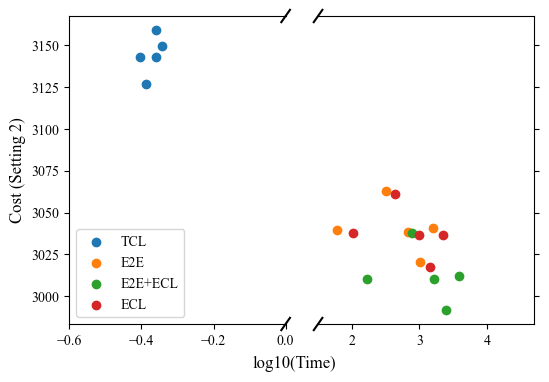

In [106]:
# 创建主图
fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,4))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 10

# 绘制 TCL 的散点图
ax.scatter(np.log10(total_time_with_N),Cost_with_N, label='TCL')
ax2.scatter(np.log10(total_time_with_N), Cost_with_N, label='TCL')

# 绘制 E2E 的散点图
ax.scatter(np.log10(total_time_with_N_e2e), Cost_with_N_e2e, label='E2E')
ax2.scatter(np.log10(total_time_with_N_e2e), Cost_with_N_e2e, label='E2E')

# 绘制 E2E+ECL 的散点图
ax.scatter(np.log10(total_time_with_N_e2e_ecl + total_time_with_N_e2e), Cost_with_N_e2e_ecl, label='E2E+ECL')
ax2.scatter(np.log10(total_time_with_N_e2e_ecl + total_time_with_N_e2e), Cost_with_N_e2e_ecl, label='E2E+ECL')

# 绘制 ECL 的散点图
ax.scatter(np.log10(total_time_with_N_online_e2e), Cost_with_N_online_e2e, label='ECL')
ax2.scatter(np.log10(total_time_with_N_online_e2e), Cost_with_N_online_e2e, label='ECL')

# 设置 x 轴范围
ax.set_xlim(-0.6, 0)
ax2.set_xlim(1.5, 4.7)

# 设置标题和标签
fig.text(0.5, 0, 'log10(Time)', ha='center',fontsize=12)

ax.set_ylabel('Cost (Setting '+str(int(2*args_train.flag_dynamic_price)+int(args_train.flag_dynamic_mode))+')',fontsize=12)

#ax.legend(loc='upper left')

# 去掉中间的空白
fig.subplots_adjust(wspace=0.15)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.yaxis.tick_right()

# 添加断轴符号
d = .02  # 断轴符号的大小
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax.legend(loc='lower left')
# 显示图形
#plt.title('The training time and operation Cost of different methods')
plt.savefig('../Figure/Time_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.png',dpi=300)
plt.show()

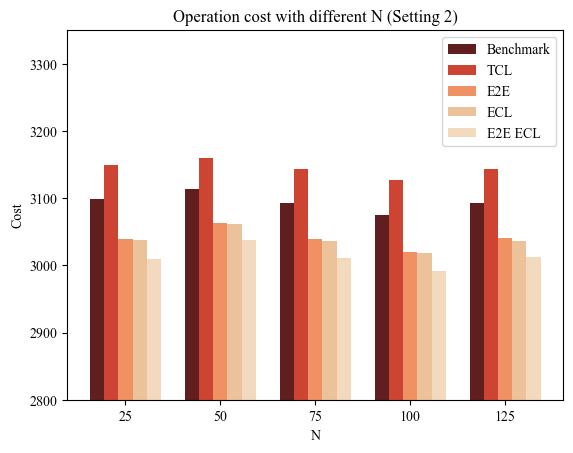

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cost_1=Cost_with_N_org
cost_2=Cost_with_N
cost_3=Cost_with_N_e2e
cost_4=Cost_with_N_online_e2e 
cost_5=Cost_with_N_e2e_ecl

# color_1 = (64/255, 3/255, 126/255)
# color_2 = (91/255, 53/255, 149/255)
# color_3 = (121/255, 111/255, 179/255)
# color_4 = (156/255, 152/255, 199/255)
# color_5 = (197/255, 197/255, 224/255)
# color_5 = (229/255, 227/255, 240/255)

color_1 = (97/255, 30/255, 30/255)
color_2 = (205/255, 68/255, 50/255)
color_3 = (239/255, 145/255, 99/255)
color_4 = (236/255, 194/255, 155/255)
color_5 = (243/255, 217/255, 190/255)

# for epsion in [1000,100,10,1,1e-1,1e-2]:
#     print('epsion:',epsion)
#     cost_3.append(np.mean(vars()['cost_list_e2e'+str(epsion)]))
#     cost_1.append(np.mean(vars()['cost_org'+str(epsion)]))
#     cost_2.append(np.mean(vars()['cost_list'+str(epsion)]))
cost_2=np.array(cost_2)
cost_1=np.array(cost_1)
cost_3=np.array(cost_3)
cost_4=np.array(cost_4)
cost_5=np.array(cost_5)
epsions = [25,50,75,100,125]
fig, ax1 = plt.subplots()

bar_width = 0.15
indices = np.arange(len(epsions))

ax1.set_xlabel('N')
ax1.set_ylabel('Cost')



ax1.bar(indices -2* bar_width, cost_1, bar_width, label='Benchmark', color=color_1)
#ax1.plot(indices -2* bar_width, cost_1, '-', color=color_1)


ax1.bar(indices- 1* bar_width, cost_2, bar_width, label='TCL', color=color_2)
#ax1.plot(indices- 1 * bar_width, cost_2, '-',  color=color_2)
ax1.bar(indices, cost_3, bar_width, label='E2E', color=color_3)
#ax1.plot(indices, cost_3, '-', color=color_3)

ax1.bar(indices + bar_width, cost_4, bar_width, label='ECL', color=color_4)
#ax1.plot(indices + bar_width, cost_4, '-', color=color_4)
ax1.bar(indices + 2 * bar_width, cost_5, bar_width, label='E2E ECL', color=color_5)
#ax1.plot(indices + 2 * bar_width, cost_5, '-', color=color_5)


ax1.legend(loc='upper left')

ax1.set_ylim(2800, 3350)

ax1.set_xticks(indices)
ax1.set_xticklabels(epsions)

ax1.legend(loc='upper right')
plt.title(r'Operation cost with different N '+'(Setting '+str(args_train.flag_dynamic_mode)+')')
plt.savefig('../Figure/Cost vs N parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.png')

dic={'Benchmark':cost_1,'TCL':cost_2,'E2E':cost_3,'Online E2E':cost_4,'E2E ECL':cost_5}
df=pd.DataFrame(dic)
df.to_csv('../Result/Different N/Parameter/Cost vs N parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')
plt.show()